In [5]:
import os
import hashlib

import bioimageio.core
import imageio
# we use napari for visualising images, you can install it via `pip install napari` or`conda install napari`
# import napari
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from bioimageio.core.prediction_pipeline import create_prediction_pipeline
from bioimageio.core.prediction import predict_with_tiling


from pathlib import Path
import z5py
from cryofib.n5_utils import read_volume

from cryofib.preprocess_utils import percentile_norm, zero_mean_unit_variance

## Use 3D UNet mouse embryo model to try to segment nuclei in the fluorescence  

https://bioimage.io/#/?id=10.5281%2Fzenodo.6383429  

10.5281/zenodo.6383429

loyal-squid

In [6]:
rdf_doi = "10.5281/zenodo.6383429"
rdf_path = "/g/kreshuk/buglakova/fibsem_segm/fluo_segmentation/models/3d-unet-mouse-embryo-fixed_pytorch_state_dict.zip"

model_resource = bioimageio.core.load_resource_description(rdf_path)

/home/buglakov/miniconda3/envs/biomodel_env/lib/python3.10/site-packages/bioimageio/spec/shared/schema.py:46: ValidationWarning: tags: Missing tags for categories: [{'modality': ['electron-microscopy', 'cryo-electron-microscopy', 'fluorescence-light-microscopy', 'transmission-light-microscopy', 'super-resolution-microscopy', 'x-ray-microscopy', 'force-microscopy', 'high-content-imaging', 'whole-slide-imaging', 'other']}, {'software': ['ilastik', 'imagej', 'fiji', 'imjoy', 'deepimagej', 'n2v']}]
  warnings.warn(msg, category=ValidationWarning)


In [7]:
model_resource

Model(format_version='0.4.6', name='3D UNet Mouse Embryo Fixed', type='model', version=<Version('0.1.0')>, root_path=PosixPath('/g/kreshuk/buglakova/biomodel_zoo_tmp/extracted_packages/ba69864bcc79a54b4e4d7061b8d97e8fd184607a5e0baa3cf06652b798714123'), attachments=<marshmallow.missing>, authors=[Author(name='V. Bondarenko', affiliation=<marshmallow.missing>, email=<marshmallow.missing>, github_user=<marshmallow.missing>, orcid=<marshmallow.missing>), Author(name='A. Wolny', affiliation=<marshmallow.missing>, email=<marshmallow.missing>, github_user=<marshmallow.missing>, orcid=<marshmallow.missing>)], badges=<marshmallow.missing>, cite=[CiteEntry(text='V. Bondarenko et al. Ex vivo Engineering Uterine Environment for Peri-implantation Mouse Development', doi=<marshmallow.missing>, url='https://github.com/kreshuklab/mouse-embryo-seg')], config={'bioimageio': {'created': '2022-03-25 01:46:26.819763', 'doi': '10.5281/zenodo.6383430', 'nickname': 'loyal-squid', 'nickname_icon': '🦑', 'owners

In [8]:
# we can e.g. check what weight formats are available in the model (pytorch_state_dict for the model used here)
print("Available weight formats for this model:", model_resource.weights.keys())
# or where the (downloaded) weight files are stored
print("Pytorch state dict weights are stored at:", model_resource.weights["pytorch_state_dict"].source)
print()
# or what inputs the model expects
print("The model requires as inputs:")
for inp in model_resource.inputs:
    print("Input with axes:", inp.axes, "and shape", inp.shape)
print()
# and what the model outputs are
print("The model returns the following outputs:")
for out in model_resource.outputs:
    print("Output with axes:", out.axes, "and shape", out.shape)

Available weight formats for this model: dict_keys(['pytorch_state_dict'])
Pytorch state dict weights are stored at: /g/kreshuk/buglakova/biomodel_zoo_tmp/extracted_packages/ba69864bcc79a54b4e4d7061b8d97e8fd184607a5e0baa3cf06652b798714123/unet-bce-dice-ab-nuclei-boundary-090121.pytorch

The model requires as inputs:
Input with axes: ('b', 'c', 'z', 'y', 'x') and shape [1, 1, 32, 128, 128]

The model returns the following outputs:
Output with axes: ('b', 'c', 'z', 'y', 'x') and shape ImplicitOutputShape(reference_tensor='raw', scale=[1.0, 2.0, 1.0, 1.0, 1.0], offset=[0.0, 0.0, 0.0, 0.0, 0.0])


In [9]:
model_resource.preprocessing

AttributeError: 'Model' object has no attribute 'preprocessing'

In [10]:
from bioimageio.core.resource_tests import test_model
test_result = test_model(model_resource)
if test_result["status"] == "failed":
    print("model test:", test_result["name"])
    print("The model test failed with:", test_result["error"])
    print("with the traceback:")
    print("".join(test_result["traceback"]))
else:
    test_result["status"] == "passed"
    print("The model passed all tests")

The model passed all tests


In [11]:
input_image = np.load(model_resource.test_inputs[0])

In [12]:
def predict_numpy(model, input_, devices=[4], weight_format=None):
    # the prediction pipeline combines preprocessing, prediction and postprocessing.
    # it should always be used for prediction with a bioimageio model
    pred_pipeline = create_prediction_pipeline(
        bioimageio_model=model, devices=devices, weight_format=weight_format
    )

    # the prediction pipeline expects inputs as xarray.DataArrays.
    # these are similar to numpy arrays, but allow for named dimensions (the dims keyword argument)
    # in bioimage.io the dims have to agree with the input axes required by the model
    axes = tuple(model.inputs[0].axes)
    input_tensor = xr.DataArray(input_, dims=axes)
    
    # the prediction pipeline call expects the same number of inputs as the number of inputs required by the model
    # in the case here, the model just expects a single input. in the case of multiple inputs use
    # prediction = pred_pipeline(input1, input2, ...)
    # or, if you have the inputs in a list or tuple
    # prediction = pred_pipeline(*inputs)
    # the call returns a list of output tensors, corresponding to the output tensors of the model
    # (in this case, we just have a single output)
    tiling = {"halo": {"x": 32, "y": 32, "z": 8}, "tile": {"x": 128, "y": 128, "z": 32}}
    prediction = predict_with_tiling(pred_pipeline, input_tensor, tiling)[0]
    return prediction

In [13]:
input_image.shape

(1, 1, 32, 128, 128)

In [14]:
prediction = predict_numpy(model_resource, input_image)

In [15]:
prediction.shape

(1, 2, 32, 128, 128)

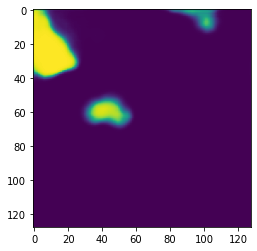

In [16]:
plt.imshow(prediction[0, 0, 16, :, :])

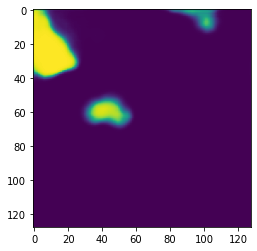

In [17]:
plt.imshow(prediction[0, 0, 16, :, :])

In [18]:
input_image.shape

(1, 1, 32, 128, 128)

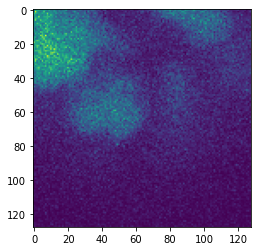

In [19]:
plt.imshow(input_image[0, 0, 16, :, :])

In [20]:
scratch_dir = Path("/scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem")
fluo_dir = scratch_dir / "fluo"
fluo_n5_path = fluo_dir / "fluo.n5"
f_fluo = z5py.File(fluo_n5_path, "a")

In [21]:
roi = np.s_[:]
raw = read_volume(f_fluo, "raw", roi)

Reading roi slice(None, None, None) of volume raw from /scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/fluo/fluo.n5
Read volume with shape (55, 3343, 1482), data type uint8


In [23]:
raw = zero_mean_unit_variance(percentile_norm(raw, 1, 99.6))

In [24]:
raw = raw[np.newaxis, np.newaxis, :, :, :]

In [25]:
raw.shape

(1, 1, 55, 3343, 1482)

In [26]:
raw.dtype

dtype('float64')

In [27]:
raw.max()

10.313563343790507

In [28]:
prediction = predict_numpy(model_resource, raw.astype(np.float32))

In [29]:
prediction.shape

(1, 2, 55, 3343, 1482)

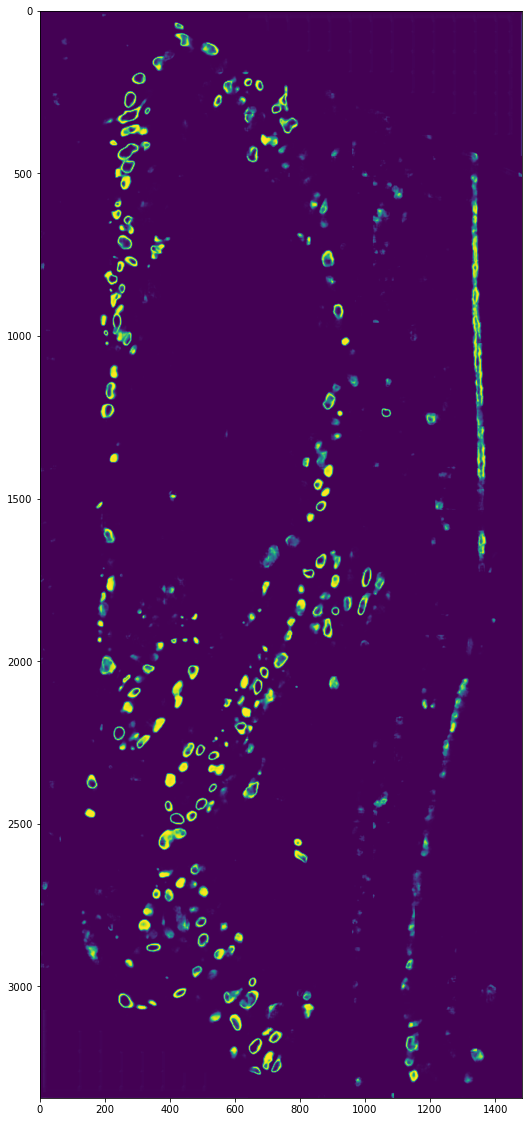

In [33]:
plt.figure(figsize=(20, 20))
plt.imshow(prediction[0, 1, 40, :, :])

In [37]:
# Store watershed
chunks = (1, 512, 512)
shape = prediction[0, 0, :, :, :].shape
compression = "gzip"
dtype = prediction.dtype

g = f_fluo["segmentation"]
ds_segm = g.create_dataset("adrian_unet_segm", shape=shape, compression="gzip",
                            chunks=chunks, dtype=dtype)
ds_segm.n_threads = 8
print("Writing segmentation")
ds_segm[:] = prediction[0, 0, :, :, :]

ds_segm = g.create_dataset("adrian_unet_boundaries", shape=shape, compression="gzip",
                            chunks=chunks, dtype=dtype)
ds_segm.n_threads = 8
print("Writing segmentation")
ds_segm[:] = prediction[0, 1, :, :, :]


Writing segmentation
Writing segmentation
